# Anomaly detection example

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM

%matplotlib inline

In [3]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

## Exploración de los datos

In [4]:
more data/realKnownCause/ambient_temperature_system_failure.csv

In [5]:
df = pd.read_csv("data/realKnownCause/ambient_temperature_system_failure.csv")

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB
None


In [7]:
# tiempos
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [8]:
# herramientas para manipular variables temporales

tt1 = pd.to_datetime(df['timestamp'][0]).to_pydatetime()
tt2 = pd.to_datetime(df['timestamp'][18]).to_pydatetime()
print tt1
print tt2
delta = tt2 - tt1
print delta.seconds/3600, 'horas'
print delta.days + delta.seconds/3600/24., 'dias'

2013-07-04 00:00:00
2013-07-04 18:00:00
18 horas
0.75 dias


In [9]:
# Pasamos todo a unidades de dias
dft = pd.to_datetime(df['timestamp'])
start_day = dft[0].to_pydatetime()
t_days = []
for i in df['timestamp']:
    day = pd.to_datetime(i).to_pydatetime()
    delta = day - start_day    
    t_days.append(delta.days + delta.seconds/3600/24.)

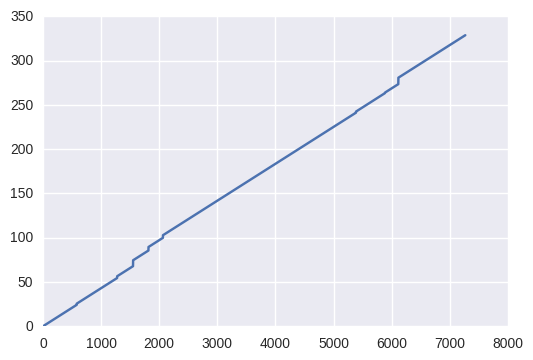

In [10]:
plt.plot(t_days)

In [11]:
# Temperatura
print(df['value'].head(10))

0    69.880835
1    71.220227
2    70.877805
3    68.959400
4    69.283551
5    70.060966
6    69.279765
7    69.369608
8    69.166714
9    68.986083
Name: value, dtype: float64


In [12]:
# Pasar los valores de temperatura a grados Celsius
T = (df['value'] - 32) * 5/9

[]

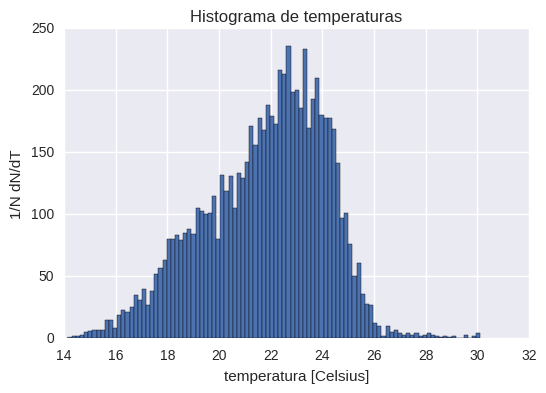

In [13]:
plt.hist(T, bins=100)
plt.title('Histograma de temperaturas')
plt.xlabel('temperatura [Celsius]')
plt.ylabel('1/N dN/dT')
plt.plot()

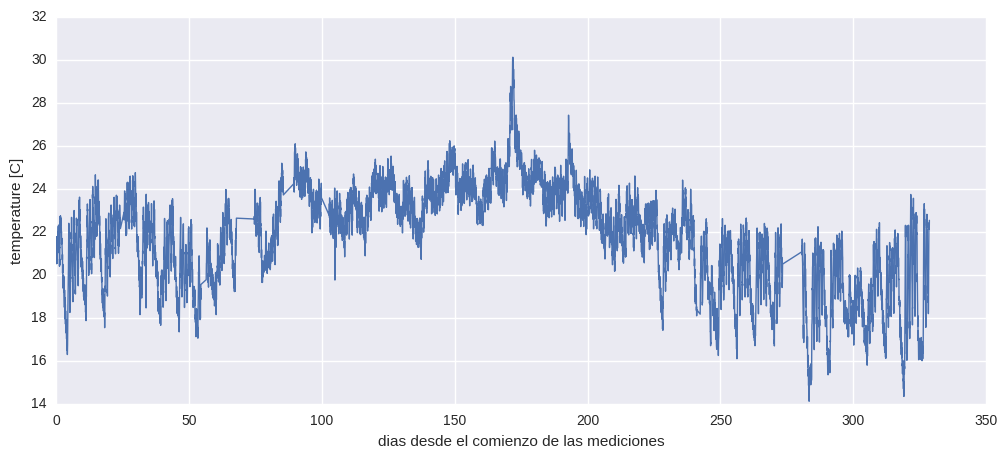

In [14]:
# Pero depende del tiempo:
fig = plt.figure(1, figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(t_days, T, linewidth=1)
ax.set_xlabel('dias desde el comienzo de las mediciones')
ax.set_ylabel('temperature [C]')

In [15]:
# Busquemos algunas características

In [17]:
# El dia de la semana (Lunes=0, Domingo=6)
t_dow = dft.dt.dayofweek

T_dow = []
for i in range(7):
    T_dow.append(T[t_dow==i])

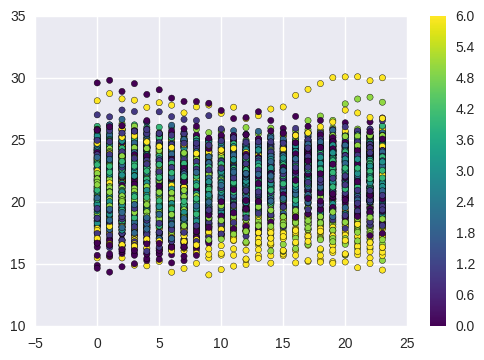

In [18]:
t_hour = dft.dt.hour
plt.scatter(t_hour, T, c=t_dow, cmap='viridis')
plt.colorbar()

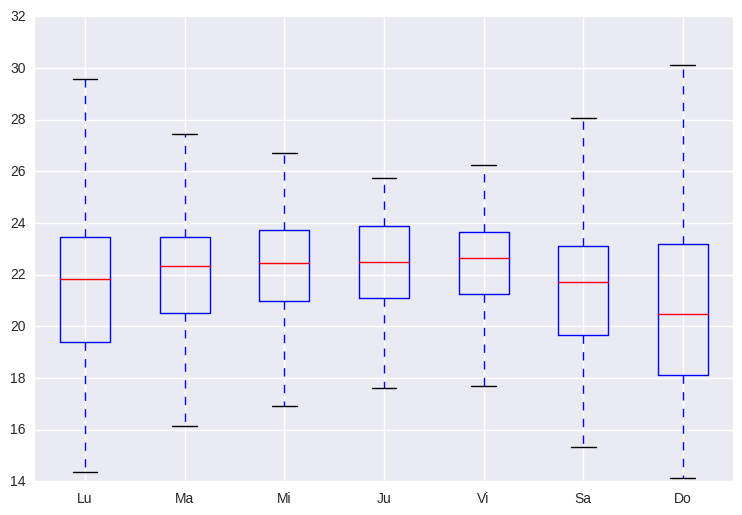

In [19]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
B = ax.boxplot(T_dow)
ax.set_xticklabels(['Lu', 'Ma', 'Mi', 'Ju','Vi','Sa','Do'])

In [20]:
import matplotlib.cm as cm
colors = cm.rainbow(t_dow)

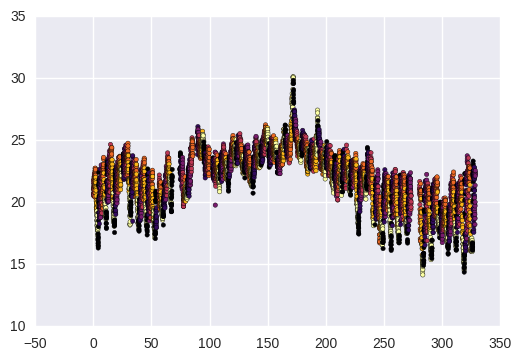

In [21]:
#for y, c in zip(T, colors):
plt.scatter(t_days, T, c=t_dow, cmap='inferno', s=10)

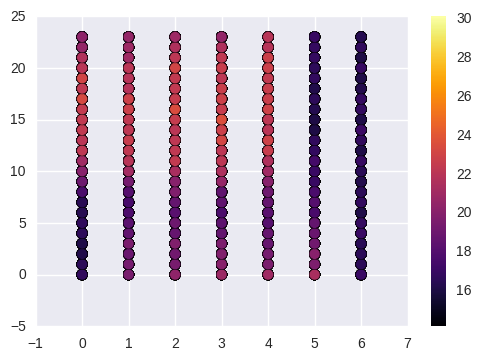

In [22]:
# https://matplotlib.org/examples/color/colormaps_reference.html
plt.scatter(t_dow, t_hour, c=T, cmap='inferno', s=60)
plt.colorbar()
plt.show()

In [23]:
df = pd.DataFrame({'T': list(T), 'days':list(t_days), 'dow': list(t_dow), 'hour': list(t_hour)})

In [24]:
df.head()

,T,days,dow,hour
0,21.044908,0.000000,3,0
1,21.789015,0.041667,3,1
2,21.598781,0.083333,3,2
3,20.533000,0.125000,3,3
4,20.713084,0.166667,3,4


## Dimensionality reduction: PCA

In [25]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features

pca = PCA(n_components=2)
data = pca.fit_transform(data)

In [26]:
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

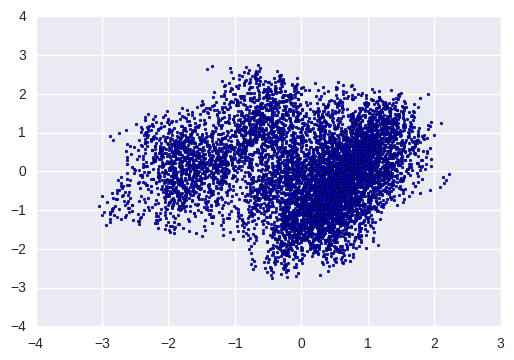

In [27]:
plt.scatter(data[0], data[1], s=4)

## Clustering: Kmeans

In [46]:
n_cluster = 8

kmeans = KMeans(n_clusters=n_cluster).fit(data)

In [47]:
# La lista de indices de los clusters:
membership = kmeans.predict(data)

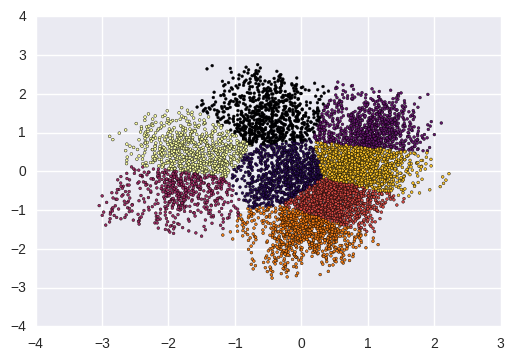

In [48]:
plt.scatter(data[0], data[1], c=membership, cmap='inferno', s=4)

## Anomaly detection

In [49]:
distance = getDistanceByPoint(data, kmeans)

In [50]:
outliers_fraction = 0.01
number_of_outliers = int(outliers_fraction*len(distance))

In [51]:
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
strange = distance >= threshold

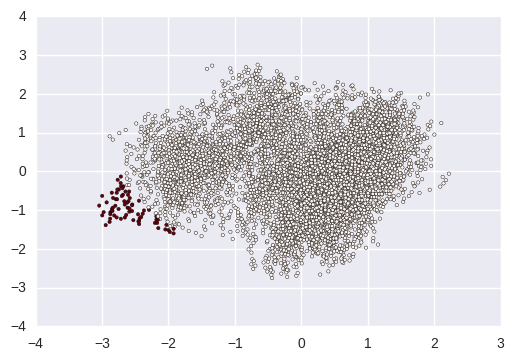

In [52]:
plt.scatter(data[0], data[1], c=strange, cmap='Reds', s=6)

In [53]:
t_out = [t_days[i] for i, s in enumerate(strange) if s]
T_out = [T[i] for i, s in enumerate(strange) if s]

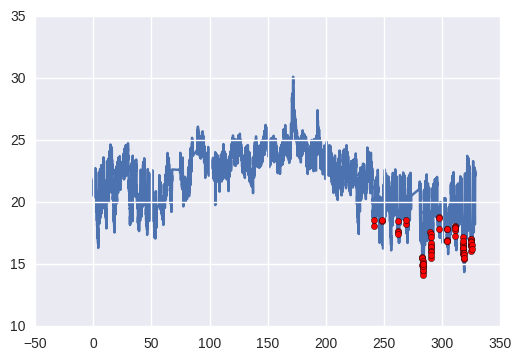

In [54]:
plt.plot(t_days, T, zorder=0)
plt.scatter(t_out, T_out, c='red', zorder=1000)
plt.show()